# Subclass DE isoform only

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

10-Nov-20 15:34:19 - 1 of 18 assignments: Astro
10-Nov-20 15:34:19 - 2 of 18 assignments: Endo
10-Nov-20 15:34:20 - 3 of 18 assignments: L2/3 IT
10-Nov-20 15:34:21 - 4 of 18 assignments: L5 IT
10-Nov-20 15:34:22 - 5 of 18 assignments: L5 PT
10-Nov-20 15:34:23 - 6 of 18 assignments: L5/6 NP
10-Nov-20 15:34:23 - 7 of 18 assignments: L6 CT
10-Nov-20 15:34:24 - 8 of 18 assignments: L6 IT
10-Nov-20 15:34:25 - 9 of 18 assignments: L6 IT Car3
10-Nov-20 15:34:26 - 10 of 18 assignments: L6b
10-Nov-20 15:34:27 - 11 of 18 assignments: Lamp5
10-Nov-20 15:34:27 - 12 of 18 assignments: Low Quality
10-Nov-20 15:34:28 - 13 of 18 assignments: Pvalb
10-Nov-20 15:34:29 - 14 of 18 assignments: SMC
10-Nov-20 15:34:29 - 15 of 18 assignments: Sncg
10-Nov-20 15:34:30 - 16 of 18 assignments: Sst
10-Nov-20 15:34:30 - 17 of 18 assignments: VLMC
10-Nov-20 15:34:31 - 18 of 18 assignments: Vip


CPU times: user 7.84 s, sys: 5.95 s, total: 13.8 s
Wall time: 13.8 s


In [7]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

10-Nov-20 15:34:35 - 1 of 18 assignments: Astro
10-Nov-20 15:34:36 - 2 of 18 assignments: Endo
10-Nov-20 15:34:37 - 3 of 18 assignments: L2/3 IT
10-Nov-20 15:34:39 - 4 of 18 assignments: L5 IT
10-Nov-20 15:34:41 - 5 of 18 assignments: L5 PT
10-Nov-20 15:34:44 - 6 of 18 assignments: L5/6 NP
10-Nov-20 15:34:45 - 7 of 18 assignments: L6 CT
10-Nov-20 15:34:47 - 8 of 18 assignments: L6 IT
10-Nov-20 15:34:49 - 9 of 18 assignments: L6 IT Car3
10-Nov-20 15:34:51 - 10 of 18 assignments: L6b
10-Nov-20 15:34:53 - 11 of 18 assignments: Lamp5
10-Nov-20 15:34:55 - 12 of 18 assignments: Low Quality
10-Nov-20 15:34:57 - 13 of 18 assignments: Pvalb
10-Nov-20 15:34:58 - 14 of 18 assignments: SMC
10-Nov-20 15:34:59 - 15 of 18 assignments: Sncg
10-Nov-20 15:35:01 - 16 of 18 assignments: Sst
10-Nov-20 15:35:02 - 17 of 18 assignments: VLMC
10-Nov-20 15:35:03 - 18 of 18 assignments: Vip


CPU times: user 17.2 s, sys: 17.5 s, total: 34.7 s
Wall time: 34.6 s


# Look at isoform markers

In [8]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").iloc[-10:-1]

,index,name,p_raw,p_corr,es
115961,Endo,Cldn5-201_ENSMUST00000043577,6.13249e-09,3.98612e-06,8.20146
1108753,VLMC,Apoe-202_ENSMUST00000167646,1.77477e-06,0.00115892,8.22725
906331,SMC,Vtn-201_ENSMUST00000017488,9.25772e-14,2.90692e-11,8.41677
1184267,Vip,Vip-201_ENSMUST00000019906,3.47426e-301,5.67347e-298,8.42662
1108752,VLMC,Apoe-209_ENSMUST00000174355,8.03526e-07,0.000524702,8.48839
131370,Endo,Ly6a-201_ENSMUST00000023248,1.00698e-09,6.5454e-07,8.52045
958996,SMC,Myl9-201_ENSMUST00000088552,1.30323e-20,4.09215e-18,8.64522
1040444,Sst,Sst-201_ENSMUST00000004480,0,2.22507e-308,9.16794
1108749,VLMC,Apoe-201_ENSMUST00000003066,6.92362e-07,0.000452113,9.18267


In [9]:
specific_cluster = "Vip"
specific_isoform = "Vip-201_ENSMUST00000019906"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [10]:
specific_gene

'Vip'

In [11]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Vip_ENSMUSG00000019772'], dtype=object)

In [12]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [17]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


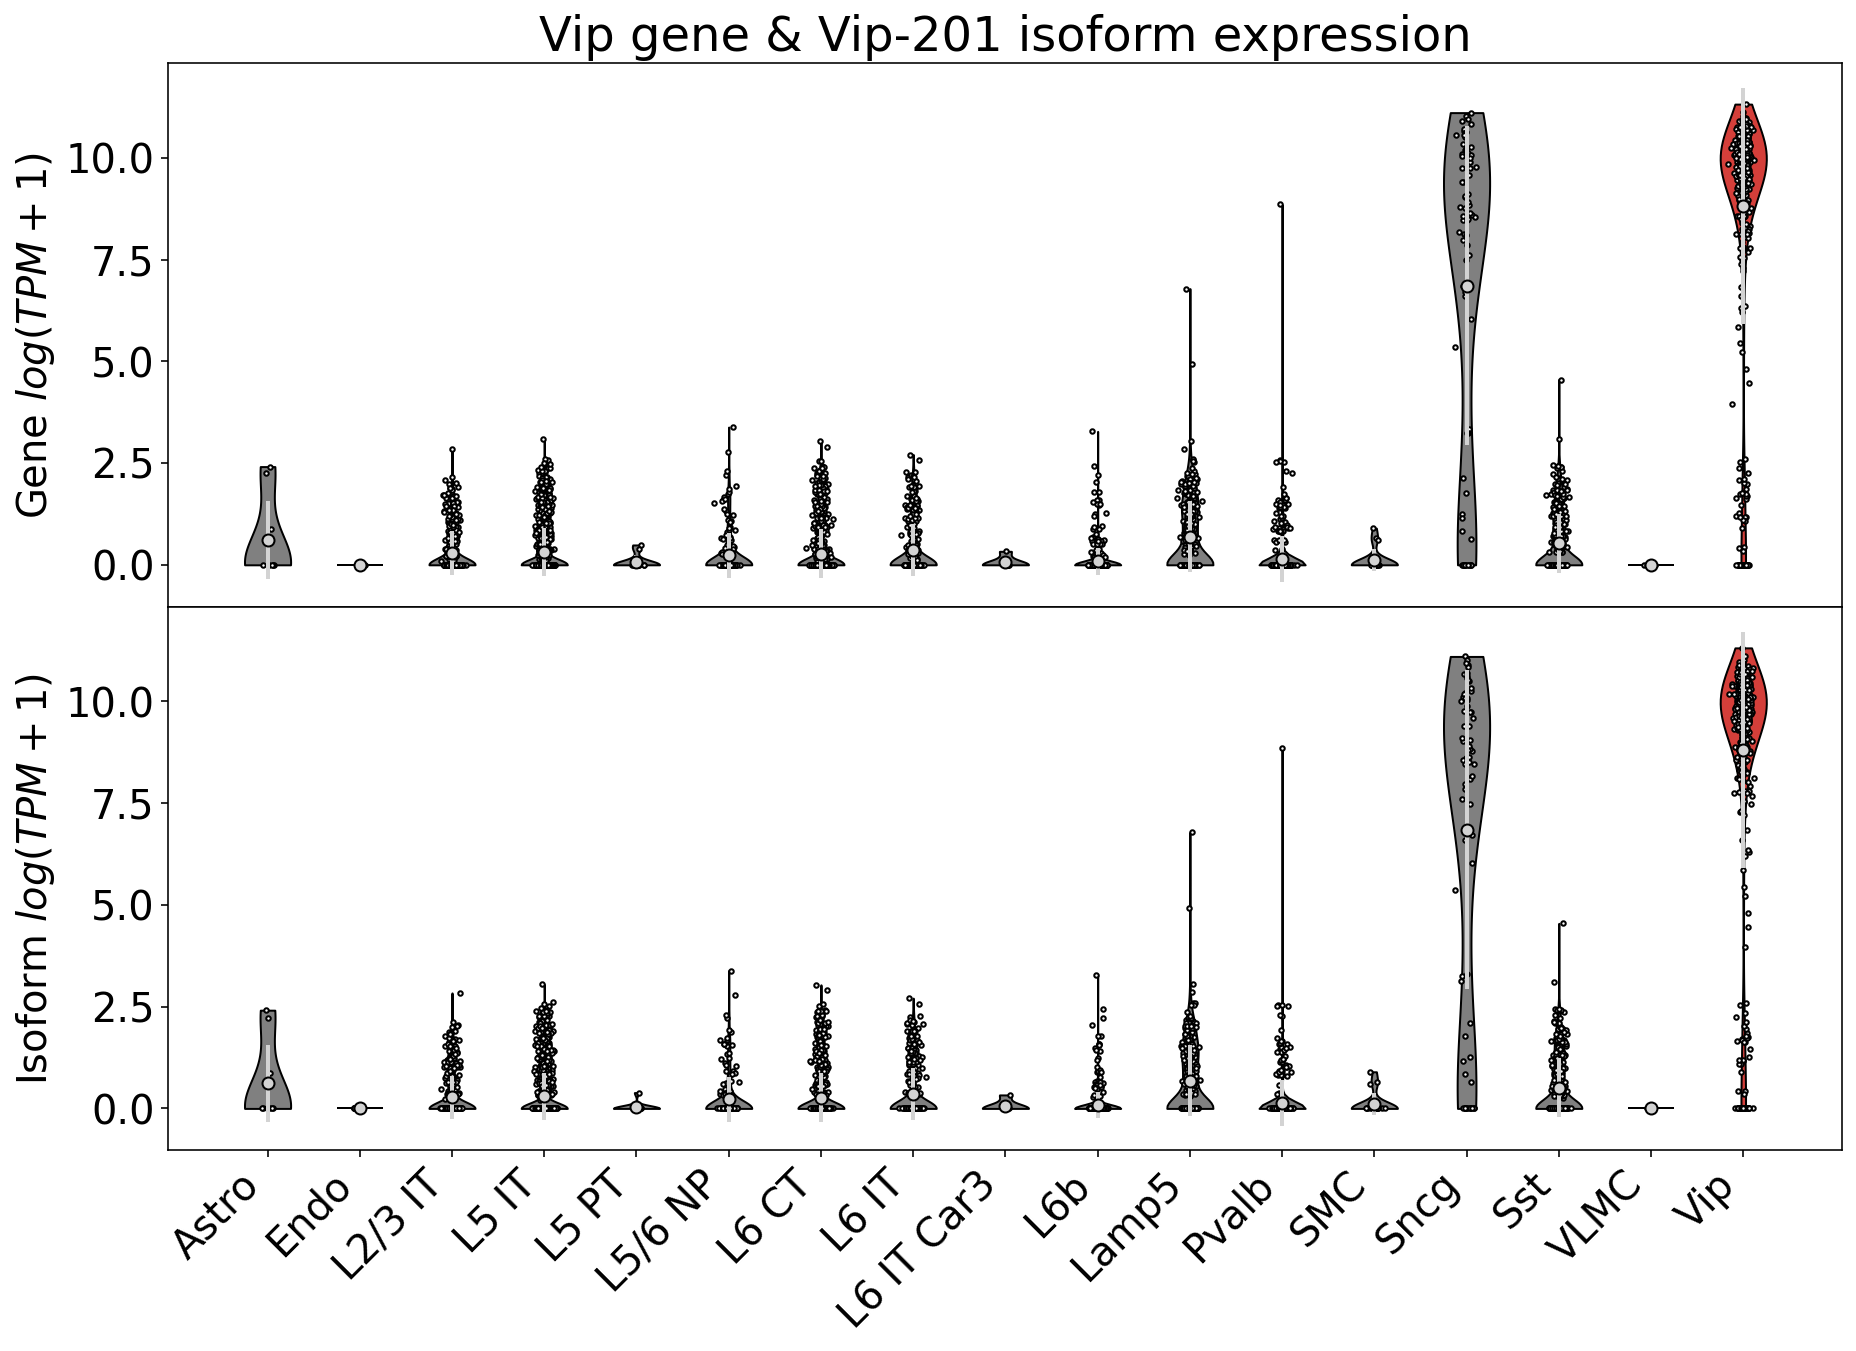

In [19]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/subclass_DE_isoform_only_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [20]:
gene

View of AnnData object with n_obs × n_vars = 6160 × 19190
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'

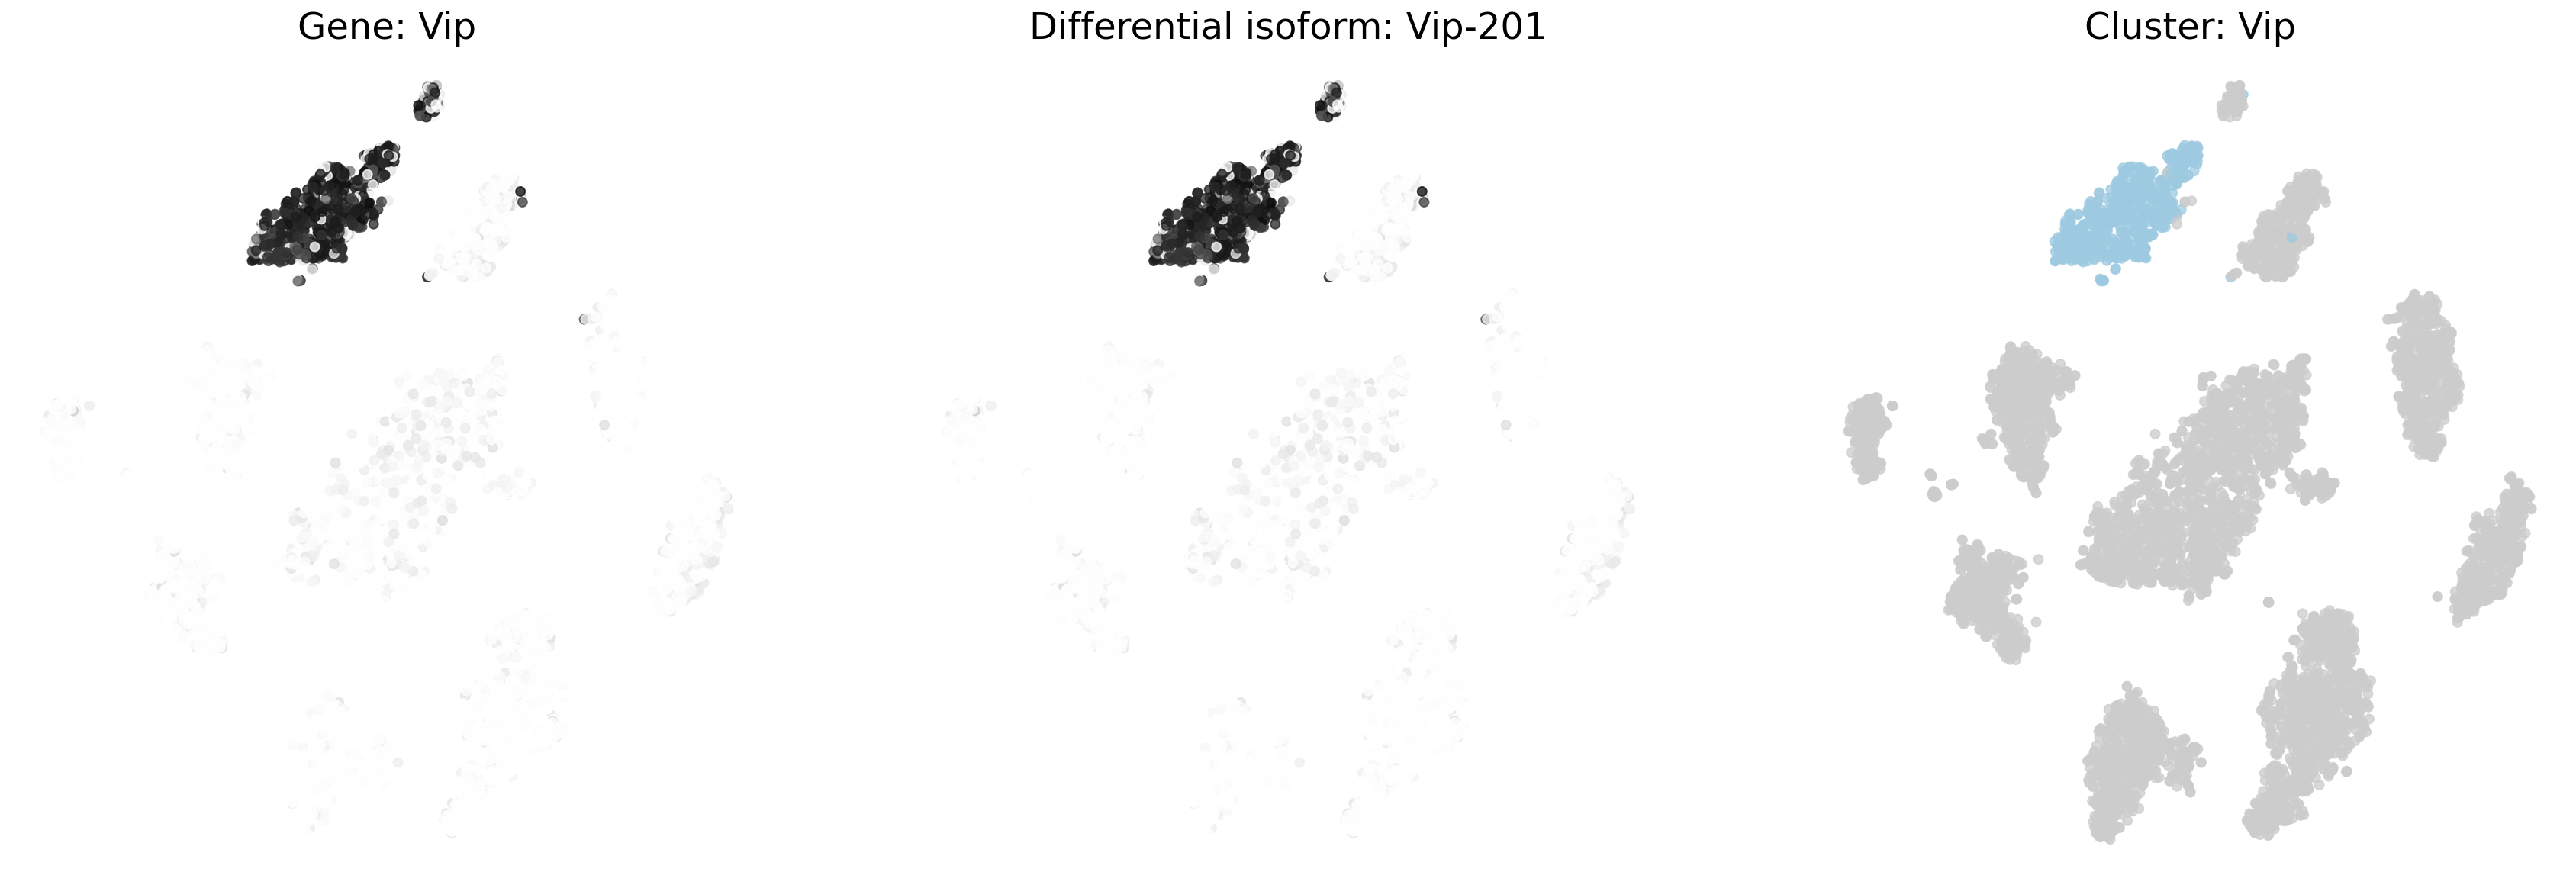

In [21]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
plt.savefig("../../figures/subclass_DE_isoform_only_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [22]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [23]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [24]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

25175 isoforms from 5372 genes identified.


In [25]:
markers_isoform.to_csv("../../tables/unordered/subclass_DE_isoform_only.csv")

In [26]:
markers_isoform.sort_values("p_corr")

,index,name,p_raw,p_corr,es
211095,L5 IT,Mef2c-222_ENSMUST00000199019,9.88131e-324,5.12939e-320,1.26093
874215,Pvalb,Pcsk1n-201_ENSMUST00000041096,1.97626e-323,6.43866e-320,0.640225
489161,L6 IT,Dynll1-203_ENSMUST00000123292,3.95253e-323,2.24187e-319,0.816316
443639,L6 CT,Mmp17-201_ENSMUST00000031390,1.77864e-322,8.42896e-319,1.41939
264708,L5 IT,Tpt1-201_ENSMUST00000110894,3.55727e-322,1.84658e-318,0.453073
...,...,...,...,...,...
248562,L5 IT,Dzank1-201_ENSMUST00000081982,1.91506e-06,0.00994106,0.170086
442016,L6 CT,Tmem234-201_ENSMUST00000102591,2.0992e-06,0.00994809,0.174155
1050562,Sst,Vdac2-201_ENSMUST00000022293,3.24113e-06,0.0099535,0.106361
873760,Pvalb,Rps21-201_ENSMUST00000059080,3.0612e-06,0.00997338,-0.0842241
